<a href="https://colab.research.google.com/github/dhruvanarware10/summeranalytics/blob/main/summeranalyticscapstoneproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv("dataset.csv")

In [18]:
df["Timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], format="%d-%m-%Y %H:%M:%S")
df.sort_values(by=["SystemCodeNumber", "Timestamp"], inplace=True)

traffic_map = {"low": 0, "medium": 0.5, "high": 1}
vehicle_weight_map = {"bike": 0.5, "car": 1.0, "truck": 1.5, "others": 0.8}

df["TrafficLevel"] = df["TrafficConditionNearby"].map(traffic_map)
df["VehicleWeight"] = df["VehicleType"].map(vehicle_weight_map).fillna(1.0)
df["OccupancyRate"] = df["Occupancy"] / df["Capacity"]
df["QueueLengthNorm"] = df["QueueLength"] / df["QueueLength"].max()
df["VehicleWeightNorm"] = df["VehicleWeight"] / max(vehicle_weight_map.values())

In [19]:
alpha_1 = 2.0
base_price = 10.0
model1_prices = []
last_prices = {}

for _, row in df.iterrows():
    lot = row["SystemCodeNumber"]
    if lot not in last_prices:
        last_prices[lot] = base_price
    occ_rate = row["OccupancyRate"]
    new_price = last_prices[lot] + alpha_1 * occ_rate
    new_price = round(min(max(new_price, 0.5 * base_price), 2.0 * base_price), 2)
    model1_prices.append(new_price)
    last_prices[lot] = new_price

df["Price_Model1"] = model1_prices

In [20]:
alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1
lambda_ = 0.5

df["Demand"] = (
    alpha * df["OccupancyRate"] +
    beta * df["QueueLengthNorm"] -
    gamma * df["TrafficLevel"] +
    delta * df["IsSpecialDay"] +
    epsilon * df["VehicleWeightNorm"]
)

d_min, d_max = df["Demand"].min(), df["Demand"].max()
df["NormalizedDemand"] = (df["Demand"] - d_min) / (d_max - d_min)

df["Price_Model2"] = base_price * (1 + lambda_ * df["NormalizedDemand"])
df["Price_Model2"] = df["Price_Model2"].clip(lower=0.5 * base_price, upper=2.0 * base_price).round(2)

In [21]:
from math import radians, cos, sin, sqrt, atan2


def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# Build a map of nearby lots within 1 km
lot_locations = df[["SystemCodeNumber", "Latitude", "Longitude"]].drop_duplicates()
lot_neighbors = {}

for i, row_i in lot_locations.iterrows():
    neighbors = []
    for j, row_j in lot_locations.iterrows():
        if row_i["SystemCodeNumber"] != row_j["SystemCodeNumber"]:
            dist = haversine(row_i["Latitude"], row_i["Longitude"], row_j["Latitude"], row_j["Longitude"])
            if dist <= 1.0:
                neighbors.append(row_j["SystemCodeNumber"])
    lot_neighbors[row_i["SystemCodeNumber"]] = neighbors


In [22]:
model3_prices = []
last_price_m3 = {}

for idx, row in df.iterrows():
    lot = row["SystemCodeNumber"]
    ts = row["Timestamp"]
    base_price = row["Price_Model2"]

    if lot not in last_price_m3:
        last_price_m3[lot] = base_price

    occ_rate = row["OccupancyRate"]
    neighbors = lot_neighbors.get(lot, [])
    nearby_prices = df[
        (df["SystemCodeNumber"].isin(neighbors)) &
        (df["Timestamp"] == ts)
    ]["Price_Model2"]

    price = base_price

    if occ_rate >= 0.95 and not nearby_prices.empty and nearby_prices.mean() < base_price:
        price = max(nearby_prices.mean() - 0.5, 0.5 * base_price)

    elif not nearby_prices.empty and nearby_prices.mean() > base_price + 1:
        price = min(base_price + 0.5, 2.0 * base_price)

    model3_prices.append(round(price, 2))
    last_price_m3[lot] = price

df["Price_Model3"] = model3_prices


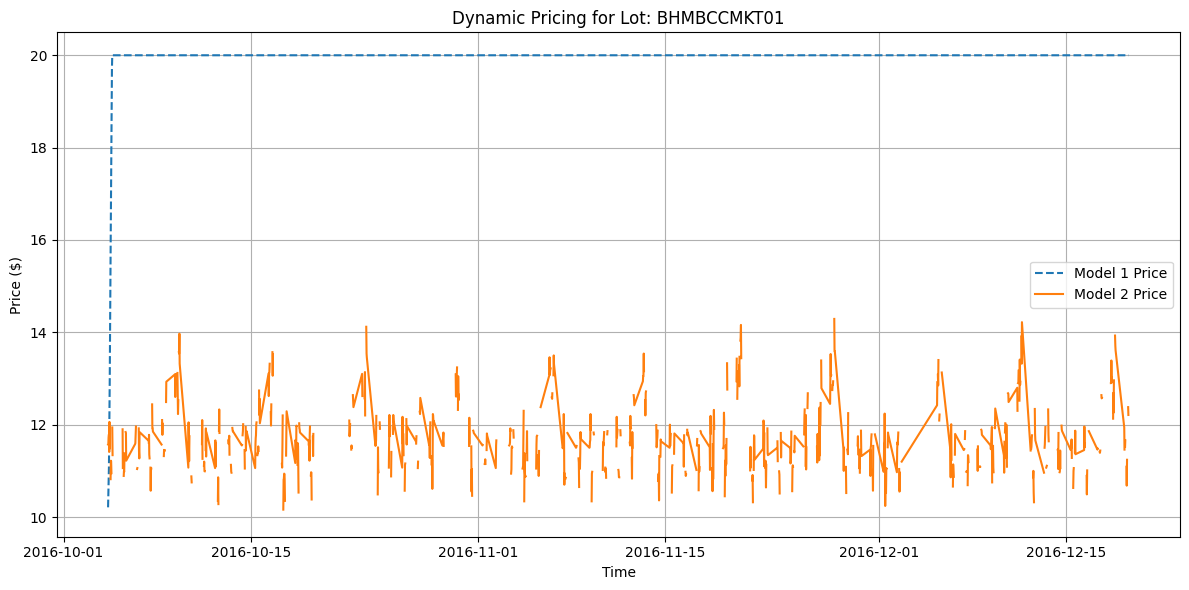

In [23]:
sample_lot = df["SystemCodeNumber"].unique()[0]
df_sample = df[df["SystemCodeNumber"] == sample_lot].sort_values("Timestamp")

plt.figure(figsize=(12,6))
plt.plot(df_sample["Timestamp"], df_sample["Price_Model1"], label="Model 1 Price", linestyle="--")
plt.plot(df_sample["Timestamp"], df_sample["Price_Model2"], label="Model 2 Price", linestyle="-")
plt.title(f"Dynamic Pricing for Lot: {sample_lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()